In [1]:
# tests/test_sedov_amr.py

import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
import jax 
jax.config.update('jax_disable_jit', False)
jax.config.update('jax_debug_nans', True)

import sys
import jax
import jax.numpy as jnp
import numpy as np

import diffhydro as dh
from diffhydro.prob_gen.initial_conditions import sedov_2d
from diffhydro.utils.diagnostics import isotropy_score


In [2]:
def run_solver(U0, params, *, dt=0.2, use_amr=False, adapt_interval=1, refine_ratio=2):
    # Matches your hydro() interface; enable AMR via the new knobs
    hydro = dh.hydro(
        fluxes=[dh.ConvectiveFlux(dh.equationmanager.EquationManager(),
                                  dh.LaxFriedrichs(equation_manager=dh.equationmanager.EquationManager(),
                                          signal_speed=dh.signal_speed_Rusanov),
                                  dh.MUSCL3(limiter="SUPERBEE"))],
        max_dt=dt,
        maxjit=False,
        use_amr=use_amr,
        adapt_interval=adapt_interval,
        refine_ratio=refine_ratio,
        splitting_schemes=[[1,2,2,1],[2,1,1,2]],
        n_super_step=80
    )
    fs = hydro.evolve(U0, params)
    return fs, hydro._amr_trace

def center_patch(x, pad):
    return x[..., pad:-pad, pad:-pad]

# ------------- tests -------------
def test_amr_conserves_mass_short_rollout():
    # Setup like tests/test_sedov.py, but short and AMR-enabled
    eq = dh.equationmanager.EquationManager()
    eq.box_size = (1.0, 1.0, 1.0)
    U0, _ = sedov_2d(1e7, 0.1, eq)   # same IC style as your sedov test :contentReference[oaicite:3]{index=3}

    params = {}

    U1, _ = run_solver(U0, params,dt=0.2, use_amr=True, adapt_interval=1, refine_ratio=2)

    m0 = jnp.sum(U0[0])
    m1 = jnp.sum(U1[0])

    # Until refluxing is fully wired, keep tolerance modest; tighten later.
    assert jnp.allclose(m0, m1, rtol=1e-3, atol=1e-5), f"Mass drift: {float(m0)} → {float(m1)}"


In [3]:


def make_gaussian_blob(
    eq,
    shape,
    peak_temp: float = 10.0,
    background_temp: float = 1.0,
    sigma: float = 3.0,
):
    """Generate a 3-D Gaussian temperature perturbation in conservative form."""

    nx, ny = shape
    sol = jnp.zeros((5, nx, ny))
    rho0 = 1.0
    sol = sol.at[0].set(rho0)

    grid = [(jnp.arange(n) + 0.5) - 0.5 * n for n in (nx, ny)]
    X, Y = jnp.meshgrid(*grid, indexing="ij")
    r2 = X**2 + Y**2 

    delta_T = peak_temp - background_temp
    temperature = jnp.roll(jnp.roll(background_temp + delta_T * jnp.exp(-r2 / (2.0 * sigma**2)),6,axis=0),6,axis=1)

    pressure = rho0 * eq.R * temperature
    total_energy = eq.get_total_energy(
        pressure,
        rho0 * jnp.ones_like(pressure),
        jnp.zeros_like(pressure),
        jnp.zeros_like(pressure),
        jnp.zeros_like(pressure),
    )
    sol = sol.at[-1].set(total_energy)

    return sol, temperature

In [4]:

eq = dh.equationmanager.EquationManager()
eq.mesh_shape=[128,128,128]
eq.box_size = (1.0, 1.0, 1.0)

UG = make_gaussian_blob(eq,[128,128],sigma=2)[0]

2025-10-14 11:53:20.927032: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a reco

In [5]:

eq = dh.equationmanager.EquationManager()
eq.box_size = (1.0, 1.0, 1.0)
eq.mesh_shape=[64,64,64]
r = 2


In [6]:
#imshow(UG[-1])

In [ ]:
params = {}
Uamr,amr_traceamr = run_solver(UG,  params,dt=0.2, use_amr=True, adapt_interval=1, refine_ratio=r)


'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring f

In [7]:

C, H, W = Uamr[0].shape
cfg0 = dh.build_level0_config(H, W, 8, 2)


NameError: name 'Uamr' is not defined

Populating the interactive namespace from numpy and matplotlib


'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)


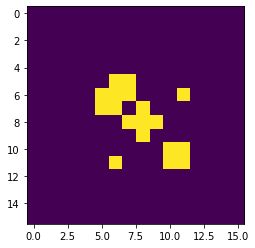

In [32]:
%pylab inline
imshow(dh.refine_mask_from_indicator_hyst(Uamr[0],cfg0,None,tau_high=25,tau_low=25))

Populating the interactive namespace from numpy and matplotlib


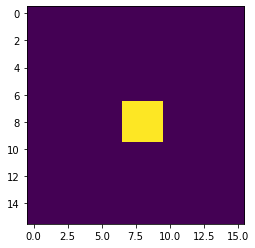

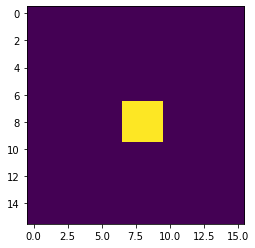

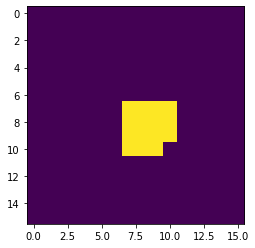

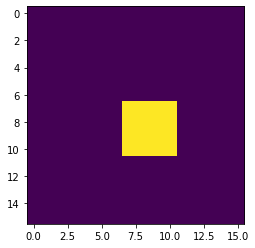

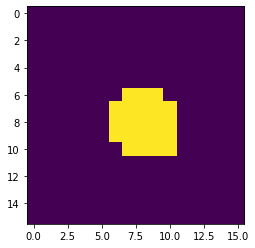

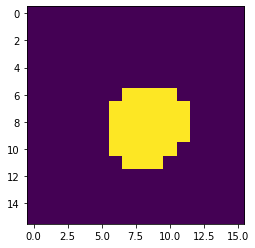

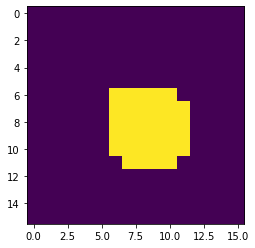

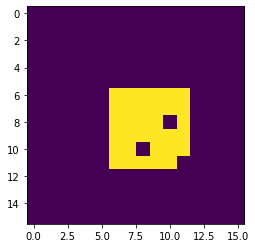

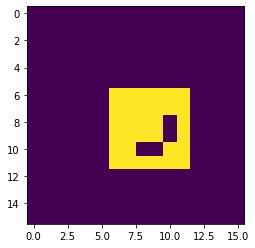

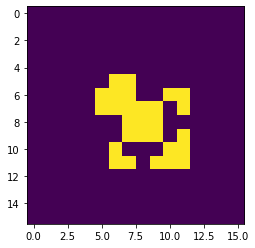

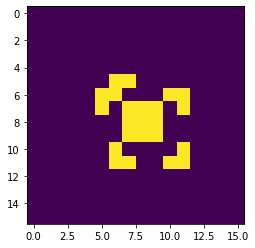

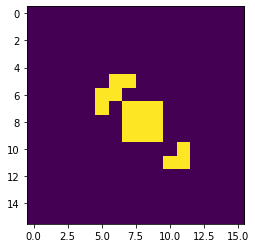

In [10]:
%pylab inline
for i in range(0,60,5):
    imshow(amr_traceamr["depth_maps"][i])
    show()



In [11]:
print("hi!")

hi!


In [12]:
amr_traceamr["depth_maps"][0].shape

(16, 16)

In [13]:
Uamr[0][0].sum(),UG[0].sum()

'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)


(Array(16382.813, dtype=float32), Array(16384., dtype=float32))

In [14]:
Uamr[0][-1].sum(),UG[-1].sum()

(Array(27681.473, dtype=float32), Array(27683.654, dtype=float32))

Populating the interactive namespace from numpy and matplotlib


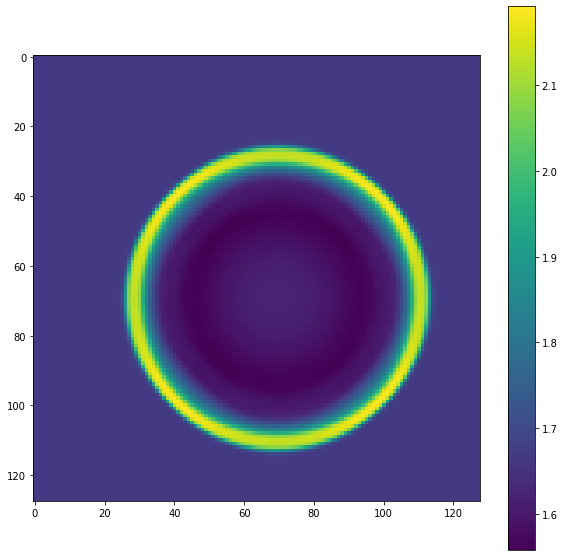

In [15]:
%pylab inline
figure(figsize=(10,10))
imshow(Uamr[0][-1])
colorbar()

In [16]:
np.arange(0,128,16)

array([  0,  16,  32,  48,  64,  80,  96, 112])

Populating the interactive namespace from numpy and matplotlib


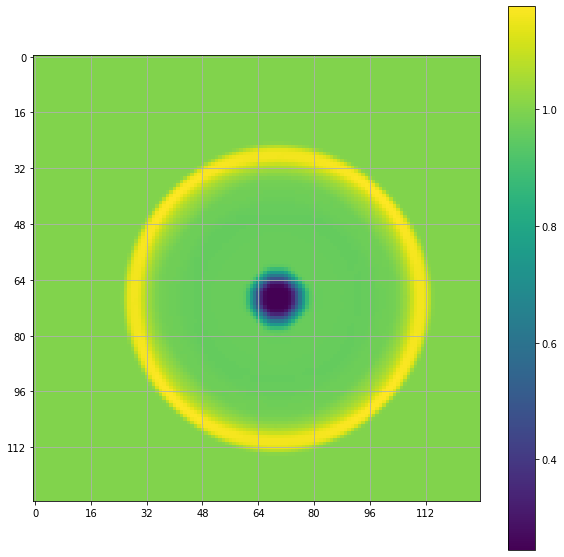

In [17]:
%pylab inline
figure(figsize=(10,10))
imshow(Uamr[0][0])#,vmin=-0.1,vmax=0.1)
grid()
xticks(np.arange(0,128,16))
yticks(np.arange(0,128,16))
colorbar()

In [23]:
params = {"n_super_step" : 20}
from diffhydro import hydro_core_uni

hydro = hydro_core_uni.hydro(
    fluxes=[dh.ConvectiveFlux(dh.equationmanager.EquationManager(),
                              dh.LaxFriedrichs(equation_manager=dh.equationmanager.EquationManager(),
                                      signal_speed=dh.signal_speed_Rusanov),
                              dh.MUSCL3(limiter="SUPERBEE"))],
    maxjit=True,
    splitting_schemes=[[1,2,2,1],[2,1,1,2]],
    n_super_step=120 #not sure why this one is ~50% more always...
)
Uamr_no = hydro.evolve(UG, params)


'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)


dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>, 10000000000.0]


'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)


Populating the interactive namespace from numpy and matplotlib


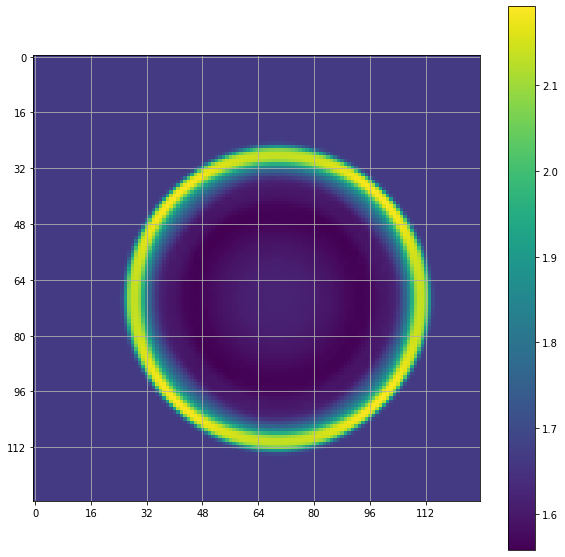

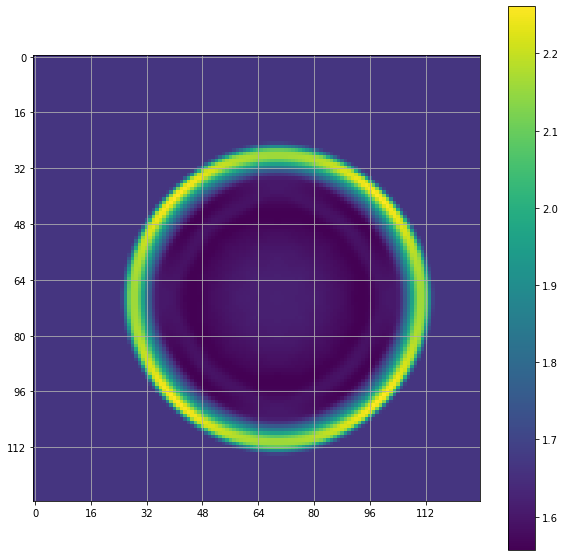

In [24]:

%pylab inline
figure(figsize=(10,10))
imshow(Uamr[0][-1])#,vmin=-0.1,vmax=0.1)
grid()
xticks(np.arange(0,128,16))
yticks(np.arange(0,128,16))
colorbar()
show()
figure(figsize=(10,10))

imshow(Uamr_no[0][-1])

xticks(np.arange(0,128,16))
yticks(np.arange(0,128,16))
grid()

colorbar()

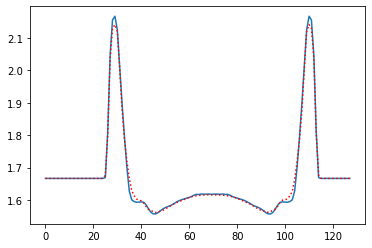

In [32]:
plot(Uamr_no[0][-1][64])
plot(Uamr[0][-1][64],"r:")

Populating the interactive namespace from numpy and matplotlib


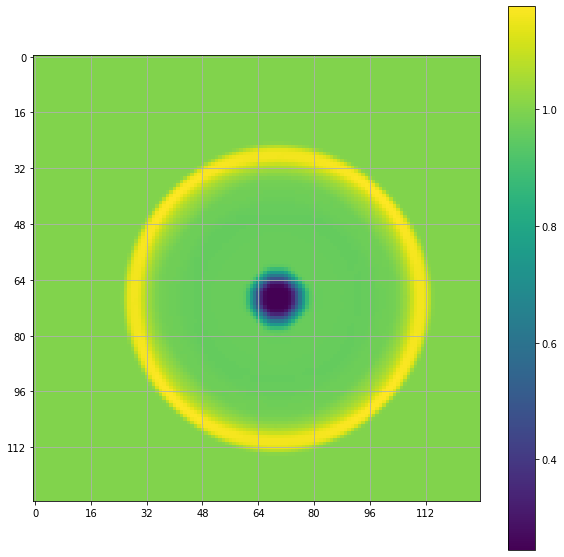

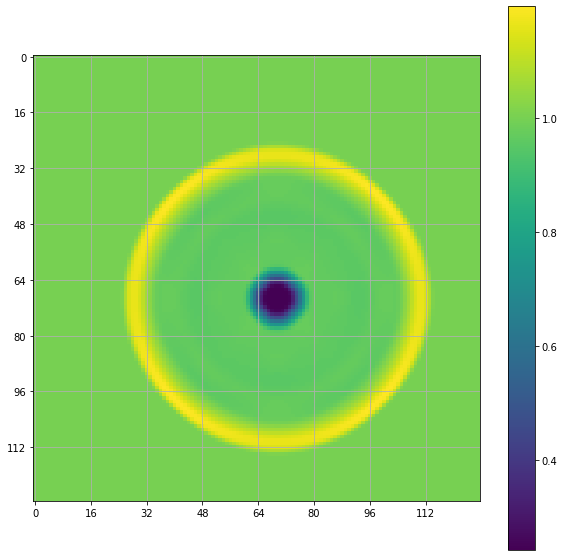

In [30]:

%pylab inline
figure(figsize=(10,10))
imshow(Uamr[0][0])#,vmin=-0.1,vmax=0.1)
grid()
xticks(np.arange(0,128,16))
yticks(np.arange(0,128,16))
colorbar()
show()
figure(figsize=(10,10))

imshow(Uamr_no[0][0])

xticks(np.arange(0,128,16))
yticks(np.arange(0,128,16))
grid()

colorbar()

In [ ]:
#no obvious bugs!